In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import os.path as osp
import gc
from dateutil.relativedelta import relativedelta
from tqdm import tqdm_notebook
import itertools 
import datetime

%matplotlib inline

In [2]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as py
import cufflinks as cf
cf.go_offline()
init_notebook_mode(connected=True)

pd.set_option('display.max_columns', 500)

/home/monty/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/home/monty/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




# TODO:
## *Аггрегировать по ЖК
## * start_square - value
## *mean_sq фичи 
## *кол-во возвратов

### *для некоторых сетов не бывает квартир определенного метража, учесть при предикте

In [3]:
flat_df = pd.read_csv('flat.csv', encoding='cp1251')
price_df = pd.read_csv('price.csv', encoding='cp1251')
status_df = pd.read_csv('status.csv', encoding='cp1251')
train_df = pd.read_csv('train.csv', encoding='cp1251')
test_df = pd.read_csv('test.csv')

In [4]:
VALID = True
TEST_START_DATE = pd.to_datetime('2018-02-01')

In [25]:
TARGET_COLS  = ['plan_l','plan_m', 'plan_s', 'start_square', 'value','vid_0', 'vid_1', 'vid_2']

In [6]:
train_df['id'] = train_df.bulk_id.astype(str)+'\\'+train_df.spalen.astype(str)
test_df['id'] = test_df.bulk_id.astype(str)+'\\'+test_df.spalen.astype(str)
flat_df['id'] = flat_df.id_bulk.astype(str)+'\\'+flat_df.spalen.astype(int).astype(str)

train_df['date1'] = pd.to_datetime(train_df['date1'])
test_df['date1'] = pd.to_datetime(test_df['date1'])
flat_df['sale'] = pd.to_datetime(flat_df['sale'])

## Parse flat sales

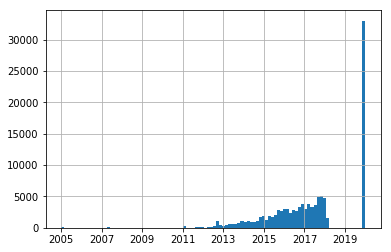

In [64]:
flat_df['sale'].hist(bins=100)

In [7]:
# min_date = flat_df['sale'].min()
min_date = datetime.datetime(year=2011, month=1, day=1)
# max_date = train_df['date1'].max()
max_date = datetime.datetime(year=2018, month=5, day=1)
dates = [min_date+relativedelta(months=m) 
         for m in itertools.takewhile(lambda m: min_date+relativedelta(months=m)<max_date+relativedelta(months=1), range(200))]
dates+=[flat_df['sale'].max()]

In [8]:
sales = dict()
for idx, set_df in tqdm_notebook(flat_df.groupby('id')):
    sales[idx] = {str(datetime.datetime(year=date.year, month=date.month, day=1)):{l:[] for l in ['-1','s','m','l'] }
                  for date in dates}
    for _, row in set_df.iterrows():
        sqr, sale_date, plan = row['square'], row['sale'], row['plan_size']
        key = str(datetime.datetime(year=sale_date.year, month=sale_date.month, day=1))
        if key in sales[idx]:
            sales[idx][key][plan.lower()].append(sqr)

HBox(children=(IntProgress(value=0, max=1040), HTML(value='')))

In [9]:
data = []
for idx in sales:
    for date in sales[idx]:
        sale_date = pd.to_datetime(date)
        data_row = [sales[idx][date][l] for l in ['-1','s','m','l']]
        data.append([idx,sale_date]+data_row)
sales_df = pd.DataFrame(data, columns = ['id','date1','plan_-1_sales','plan_s_sales','plan_m_sales','plan_l_sales'])

In [10]:
sales_df

id      date1 plan_-1_sales  \
0      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-01-01            []   
1      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-02-01            []   
2      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-03-01            []   
3      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-04-01            []   
4      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-05-01            []   
5      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-06-01            []   
6      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-07-01            []   
7      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-08-01            []   
8      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-09-01            []   
9      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-10-01            []   
10     01778D74-9326-E711-96FE-001EC9D5643C\0 2011-11-01            []   
11     01778D74-9326-E711-96FE-001EC9D5643C\0 2011-12-01            []   
12     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-01-01            []   
13     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-02-01            []   
14     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-03-01            []   
15     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-04-01            []   
16     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-05-01            []   
17     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-06-01            []   
18     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-07-01            []   
19     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-08-01            []   
20     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-09-01            []   
21     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-10-01            []   
22     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-11-01            []   
23     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-12-01            []   
24     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-01-01            []   
25     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-02-01            []   
26     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-03-01            []   
27     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-04-01            []   
28     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-05-01            []   
29     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-06-01            []   
...                                       ...        ...           ...   
93570  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-01-01            []   
93571  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-02-01            []   
93572  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-03-01            []   
93573  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-04-01            []   
93574  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-05-01            []   
93575  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-06-01            []   
93576  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-07-01            []   
93577  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-08-01            []   
93578  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-09-01            []   
93579  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-10-01            []   
93580  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-11-01            []   
93581  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-12-01            []   
93582  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-01-01            []   
93583  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-02-01            []   
93584  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-03-01            []   
93585  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-04-01            []   
93586  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-05-01            []   
93587  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-06-01            []   
93588  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-07-01            []   
93589  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-08-01            []   
93590  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-09-01            []   
93591  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-10-01            []   
93592  FF3814A9-9F7D-E711-8530-00505688958B\3 2

In [10]:
for col in ['plan_-1_sales','plan_s_sales','plan_m_sales','plan_l_sales']:
    sales_df['_'.join(col.split('_')[:-1]+['value'])] = sales_df[col].apply(np.sum)
    sales_df['_'.join(col.split('_')[:-1]+['sold'])] = sales_df[col].apply(len)
    
    mean_square = sales_df.groupby('id')[col].apply(lambda x: np.hstack(x.values).mean())
    sales_df = sales_df.merge(mean_square.rename('_'.join(col.split('_')[:-1]+['mean_square'])).reset_index(),
                              on='id', how='left')

/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

Mean of empty slice.

/home/monty/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



In [11]:
sales_df

id      date1 plan_-1_sales  \
0      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-01-01            []   
1      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-02-01            []   
2      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-03-01            []   
3      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-04-01            []   
4      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-05-01            []   
5      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-06-01            []   
6      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-07-01            []   
7      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-08-01            []   
8      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-09-01            []   
9      01778D74-9326-E711-96FE-001EC9D5643C\0 2011-10-01            []   
10     01778D74-9326-E711-96FE-001EC9D5643C\0 2011-11-01            []   
11     01778D74-9326-E711-96FE-001EC9D5643C\0 2011-12-01            []   
12     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-01-01            []   
13     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-02-01            []   
14     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-03-01            []   
15     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-04-01            []   
16     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-05-01            []   
17     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-06-01            []   
18     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-07-01            []   
19     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-08-01            []   
20     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-09-01            []   
21     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-10-01            []   
22     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-11-01            []   
23     01778D74-9326-E711-96FE-001EC9D5643C\0 2012-12-01            []   
24     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-01-01            []   
25     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-02-01            []   
26     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-03-01            []   
27     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-04-01            []   
28     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-05-01            []   
29     01778D74-9326-E711-96FE-001EC9D5643C\0 2013-06-01            []   
...                                       ...        ...           ...   
93570  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-01-01            []   
93571  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-02-01            []   
93572  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-03-01            []   
93573  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-04-01            []   
93574  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-05-01            []   
93575  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-06-01            []   
93576  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-07-01            []   
93577  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-08-01            []   
93578  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-09-01            []   
93579  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-10-01            []   
93580  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-11-01            []   
93581  FF3814A9-9F7D-E711-8530-00505688958B\3 2016-12-01            []   
93582  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-01-01            []   
93583  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-02-01            []   
93584  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-03-01            []   
93585  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-04-01            []   
93586  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-05-01            []   
93587  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-06-01            []   
93588  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-07-01            []   
93589  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-08-01            []   
93590  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-09-01            []   
93591  FF3814A9-9F7D-E711-8530-00505688958B\3 2017-10-01            []   
93592  FF3814A9-9F7D-E711-8530-00505688958B\3 2

In [11]:
sales_df['flat_df_value'] = sales_df[['plan_-1_value','plan_s_value','plan_m_value','plan_l_value']].sum(axis=1)

In [12]:
train_df.shape

(8726, 56)

In [13]:
match_val = train_df.merge(sales_df.drop(columns=['plan_-1_sales','plan_s_sales','plan_m_sales','plan_l_sales']),
                                   on=['id','date1'], how='left')[['value','flat_df_value']]

In [14]:
train_df = train_df[~(np.abs(match_val['value']-match_val['flat_df_value'])>1)]
train_df.shape

(8718, 56)

In [15]:
df = pd.concat([train_df, test_df])[train_df.columns]

In [16]:
df = df.merge(sales_df.drop(columns=['plan_-1_sales','plan_s_sales','plan_m_sales','plan_l_sales','flat_df_value']),
                                   on=['id','date1'], how='left')

In [156]:
value_from_means = sum([df['plan_{}_sold'.format(s)]*df['plan_{}_mean_square'.format(s)].fillna(0) for s in ['-1','s','m','l']])
np.sqrt(np.mean((df['value'] - value_from_means).dropna()**2))

4.867107741092594

In [17]:
square_from_means = sum([df['plan_{}'.format(s)]*df['plan_{}_mean_square'.format(s)].fillna(0) for s in ['s','m','l']])
np.sqrt(np.mean((df['start_square'] - square_from_means).dropna()**2))

73.06800730704768

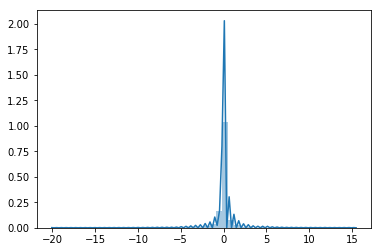

In [184]:
sns.distplot((df['mean_sq']- square_from_means/sum([df['plan_{}'.format(s)].fillna(0) for s in ['s','m','l']])).dropna())

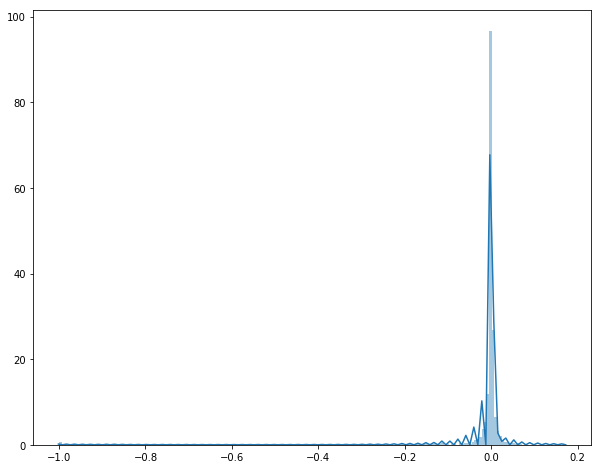

In [139]:
plt.figure(figsize=(10,8))
sns.distplot(((square_from_means-df['start_square'])/df['start_square']).dropna(), bins=200)

In [17]:
# df['id'] = df.bulk_id.astype(str)+'\\'+df.spalen.astype(str)
df = df.merge(df.groupby('id')['month_cnt'].min().rename('month_sale_start').reset_index(),
               on='id', how='left')
df['months_after_start'] = df['month_cnt'] - df['month_sale_start']

In [18]:
df['square_ratio_m/s'] = df['plan_m_mean_square']/df['plan_s_mean_square']
df['square_ratio_l/m'] = df['plan_l_mean_square']/df['plan_m_mean_square']
df['square_ratio_l/s'] = df['plan_l_mean_square']/df['plan_s_mean_square']

In [19]:
df['start_all_flats_count'] = df['plan_s']+df['plan_m']+df['plan_l']

In [26]:
TARGET_COLS +=['plan_-1_value', 'plan_-1_sold','plan_s_value', 'plan_s_sold', 
'plan_m_value','plan_m_sold', 'plan_l_value', 'plan_l_sold']+\
['start_all_flats_count']

In [27]:
# TODO: features from "future" for test part
def unroll_history(df, target_cols=TARGET_COLS, months_before = 3, months_forward = 3):

    out_df = []
    for _, set_df in tqdm_notebook(df.groupby('id')):
        min_date, max_date = set_df.date1.min(), set_df.date1.max()
        dates = [min_date+relativedelta(months=m) 
                 for m in itertools.takewhile(lambda m: min_date+relativedelta(months=m)<max_date, range(36))]
        train_dates = list(filter(lambda d: d < TEST_START_DATE, dates))
        set_df = set_df.set_index('date1').sort_index()
        
        unrolled_df =[]
        for date in (train_dates+[TEST_START_DATE]):
            data_df = []
            for m in range(months_forward):
                dt = date+relativedelta(months=m)
                if dt not in set_df.index:
                    continue
                row = set_df.loc[dt].copy()
                row['months_forward'] = m
                row['base_date'] = date 
                data_df.append(row)

            past_targets = []
            for m in range(1,months_before+1):
                dt = date-relativedelta(months=m)
                if dt in set_df.index:
                    to_append = set_df.loc[dt][target_cols]
                else:
                    to_append = pd.Series(index=target_cols)
                to_append = to_append.rename(lambda s: s+'/'+ str(m)+'_months_before')
                past_targets.append(to_append)
            past_targets = pd.concat(past_targets, axis=0)
            if len(data_df) != 0:
                data_df = pd.concat([pd.concat([s,past_targets] )for s in data_df], axis=1).T
                data_df['base_date'] = pd.to_datetime(data_df['base_date'])
                unrolled_df.append(data_df)
        if len(unrolled_df)!= 0:
            out_df.append(pd.concat(unrolled_df))
    return pd.concat(out_df)
unrolled_df = unroll_history(df)
unrolled_df.reset_index(drop=True, inplace=True)

HBox(children=(IntProgress(value=0, max=941), HTML(value='')))

In [28]:
unrolled_df['start_square_residual/1_months_before'] =\
    unrolled_df['start_square/1_months_before']-unrolled_df['value/1_months_before']
unrolled_df['start_all_flats_count_residual/1_months_before']=\
unrolled_df['start_all_flats_count/1_months_before'] - unrolled_df[['plan_-1_sold/1_months_before', 'plan_s_sold/1_months_before',
        'plan_m_sold/1_months_before', 'plan_l_sold/1_months_before']].fillna(0).sum(axis=1)

In [31]:
for plan in ['plan_s','plan_m','plan_l']:
    unrolled_df['{}_start_count_residual/1_months_before'.format(plan)]=\
        unrolled_df['{}/1_months_before'.format(plan)] - unrolled_df['{}_sold/1_months_before'.format(plan)].fillna(0)

In [32]:
unrolled_df.sort_values('months_forward', inplace=True)
look_forward_features = ['mean_sq','price']
for forward in [1,2]:
    for feat in look_forward_features:
        unrolled_df['{feat}/{m}_months_forward'.format(feat=feat,m=forward)] =\
            unrolled_df[['id','base_date',feat]].groupby(['id','base_date']).shift(-forward)[feat].ravel()

In [82]:
unrolled_df['meta_resudial'] = unrolled_df['mean_sq/1_months_forward'].astype(float)*unrolled_df['start_all_flats_count_residual/1_months_before'].astype(float)-\
    unrolled_df['start_square_residual/1_months_before'].astype(float)

In [83]:
unrolled_df['meta_resudial'] = unrolled_df['meta_resudial'].ravel() - unrolled_df[['id','base_date','meta_resudial']].groupby(['id','base_date']).shift(1)['meta_resudial'].fillna(0).ravel()

In [47]:
# unrolled_df_with_meta = []
# for _, set_df in tqdm_notebook(unrolled_df.groupby(['id','base_date'])):   
#     months_forward_idx = set_df['months_forward']
#     set_df = set_df.set_index('months_forward').reindex([0,1,2])
#     mean_sq = np.float64(set_df['mean_sq'][1:])
#     meta_resudial = mean_sq*set_df['start_flat_count_residual/1_months_before'][:-1]-\
#             set_df['start_square_residual/1_months_before'][:-1]  
    
#     meta_resudial = pd.Series(meta_resudial).fillna(0)
#     meta_resudial[1] = meta_resudial[1]-meta_resudial[0]
    
#     set_df['meta_resudial'] = [meta_resudial[0],meta_resudial[1], np.nan]
    
#     for plan in ['plan_-1','plan_s','plan_m','plan_l']:
#         plan_meta_resudial = np.float64(meta_resudial)/(mean_sq-np.float64(set_df['{}_mean_square'.format(plan)][:-1]))
#         set_df['{}_meta_resudial'.format(plan)] = [plan_meta_resudial[0],plan_meta_resudial[1], np.nan]
#     unrolled_df_with_meta.append(set_df.reindex(months_forward_idx).reset_index())
# unrolled_df_with_meta = pd.concat(unrolled_df_with_meta)

HBox(children=(IntProgress(value=0, max=9642), HTML(value='')))

KeyError: 'start_flat_count_residual/1_months_before'

In [57]:
if VALID :
    train_data = unrolled_df[unrolled_df.base_date <= pd.to_datetime('2017-10-01')]
    test_data = unrolled_df[(unrolled_df.base_date > pd.to_datetime('2017-10-01')) &
                            (unrolled_df.base_date <= pd.to_datetime('2018-01-01'))]
else:
    train_data = unrolled_df[unrolled_df.base_date <= pd.to_datetime('2018-01-01')]
    test_data = unrolled_df[unrolled_df.base_date > pd.to_datetime('2018-01-01')]

In [58]:
PLAN_PREFIX = ['plan_-1','plan_s','plan_m','plan_l']
def melt_by_plan(data, plan_prefix = PLAN_PREFIX):
    plan_cols = list(filter(lambda c: sum([pref in c for pref in plan_prefix])>0,data.columns))
    nonplan_cols = list(filter(lambda c: c not in plan_cols,data.columns))

    melted = []
    for plan in plan_prefix:
        curr_plan_cols = list(filter(lambda s: plan in s, plan_cols))
        curr_plan_df = data[curr_plan_cols]
        curr_plan_df= curr_plan_df.rename(mapper =lambda c: c.replace(plan,'flats'), axis=1)
        curr_plan_df['plan_size'] = plan
        melted.append(pd.concat([data[nonplan_cols], curr_plan_df],axis=1))
    return pd.concat(melted)

In [59]:
train_data = melt_by_plan(train_data).reset_index(drop=True)
test_data = melt_by_plan(test_data).reset_index(drop=True)
# hold_data = melt_by_plan(hold_data).reset_index(drop=True)

In [60]:
train_data = train_data[~train_data['flats_mean_square'].isna()]
test_data = test_data[~test_data['flats_mean_square'].isna()]
# hold_data = hold_data[~hold_data['flats_mean_square'].isna()]

In [61]:
target_cols = ['flats', 'flats_sold', 'flats_value']+list(set(train_data.columns)&set(TARGET_COLS))
nontarget_cols = [c for c in train_data.columns if c not in target_cols]

In [62]:
if VALID:
    test_data = test_data.loc[
        test_data[target_cols].dropna(axis=0).index]
#     hold_data = hold_data.loc[
#         hold_data[target_cols].dropna(axis=0).index]

train_data = train_data.loc[
    train_data[target_cols].dropna(axis=0).index]

In [63]:
X_train = train_data[nontarget_cols]
y_train = train_data[target_cols]

X_test = test_data[nontarget_cols]
y_test = test_data[target_cols]

# X_hold = hold_data[nontarget_cols]
# y_hold = hold_data[target_cols]

# Train LightGBM

In [64]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

In [65]:
categorical = ['Лифт', 'Кондиционирование', 'Огорожена территория',
       'Подземная парковка', 'ФОК', 'Кладовые', 'Система мусоротведения',
       'Автомойка', 'Двор без машин', 'Колясочные','Класс объекта',
       'Спортивная площадка', 'Входные группы']
key_category = ['bulk_id', 'spalen','plan_size']
to_drop = ['month','month_sale_start','month_cnt', 'id']

target_col = 'flats_sold'
# target_col = 'flats_value'

In [66]:
#impute missing
X_train = X_train.fillna(-1).drop(columns=to_drop)
X_test = X_test.fillna(-1).drop(columns=to_drop)

In [67]:
tmp = pd.concat([X_train, X_test])
# tmp = pd.concat([X_train, X_test, X_hold])
for col in categorical:
    le = LabelEncoder()
    le.fit(tmp[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
#     X_hold[col] = le.transform(X_hold[col])

key_encoder = dict()   
for col in key_category:
    le = LabelEncoder()
    le.fit(tmp[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
#     X_hold[col] = le.transform(X_hold[col])
    key_encoder[col]=le
    
# categorical+=key_category
categorical+=['spalen']

In [68]:
lgb_train = lgb.Dataset(X_train.drop(columns=['bulk_id','base_date']), y_train[target_col],
                        weight=X_train['flats_mean_square']
                        ,free_raw_data=False)
if VALID:
    lgb_eval = lgb.Dataset(X_test.drop(columns=['bulk_id','base_date']), y_test[target_col], 
                           weight=X_test['flats_mean_square']
                           ,reference=lgb_train, free_raw_data=False)
#     lgb_hold = lgb.Dataset(X_hold.drop(columns=['bulk_id','base_date']), y_hold[target_col], 
#                        weight=X_hold['flats_mean_square']
#                        ,reference=lgb_train, free_raw_data=False)

In [84]:
def eval_model():
    val_df = pd.concat([X_test, y_test], axis=1)
    val_df['pred']= gbm.predict(X_test.drop(columns=['bulk_id', 'base_date']))
    if target_col == 'flats_sold':
        val_df['pred']= val_df['pred']*val_df['flats_mean_square']
    elif target_col == 'flats_value':
        pass
    else:
        raise Exception()
    value = val_df.groupby(['bulk_id','spalen','base_date','months_forward'])['value'].max()
    pred_value = val_df.groupby(['bulk_id','spalen','base_date','months_forward'])['pred'].sum()
    print('RMSE: ', np.sqrt(np.mean((value-pred_value)**2)))
    
def rmse(preds, train_data):
    labels = train_data.get_label()
    return 'rmse', np.sqrt(np.mean((labels - preds)**2)), False

params = {
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'metric': 'poisson',
    'num_leaves': 200,
    'learning_rate': 0.05,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'bagging_freq': 6,
}

if VALID:
    gbm_history=dict()
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=427,
#                     early_stopping_rounds = 0,
                    valid_sets=[lgb_eval], 
                    categorical_feature=categorical,
                    callbacks =[lgb.record_evaluation(gbm_history)],
                   verbose_eval=50)
    eval_model()
    
else:
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=450,
                valid_sets=lgb_train, 
                categorical_feature=categorical,
               verbose_eval=50)


[50]	valid_0's poisson: -0.817139
[100]	valid_0's poisson: -1.01166
[150]	valid_0's poisson: -1.07015
[200]	valid_0's poisson: -1.10124
[250]	valid_0's poisson: -1.11713
[300]	valid_0's poisson: -1.12829
[350]	valid_0's poisson: -1.13904
[400]	valid_0's poisson: -1.14629
RMSE:  169.1973996539211


Training until validation scores don't improve for 5 rounds.
[50]	valid_0's poisson: -0.789303
[100]	valid_0's poisson: -0.981817
[150]	valid_0's poisson: -1.03555
[200]	valid_0's poisson: -1.06535
[250]	valid_0's poisson: -1.0828
[300]	valid_0's poisson: -1.09835
[350]	valid_0's poisson: -1.10941
[400]	valid_0's poisson: -1.11875
Early stopping, best iteration is:
[427]	valid_0's poisson: -1.12294
RMSE:  169.56965532939148

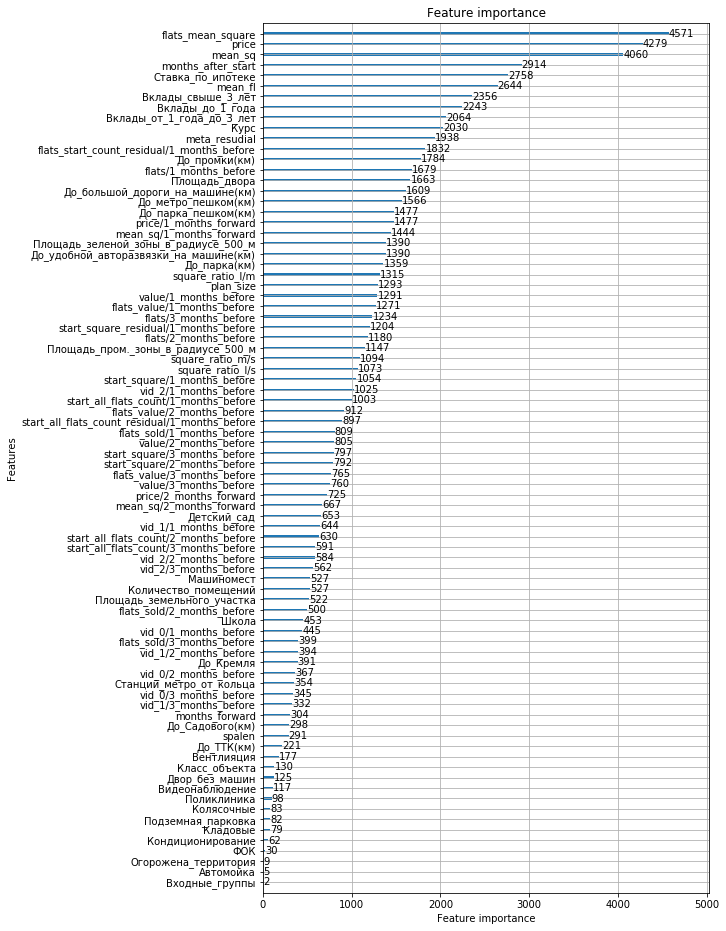

In [71]:
lgb.plot_importance(gbm, figsize=(8,16))

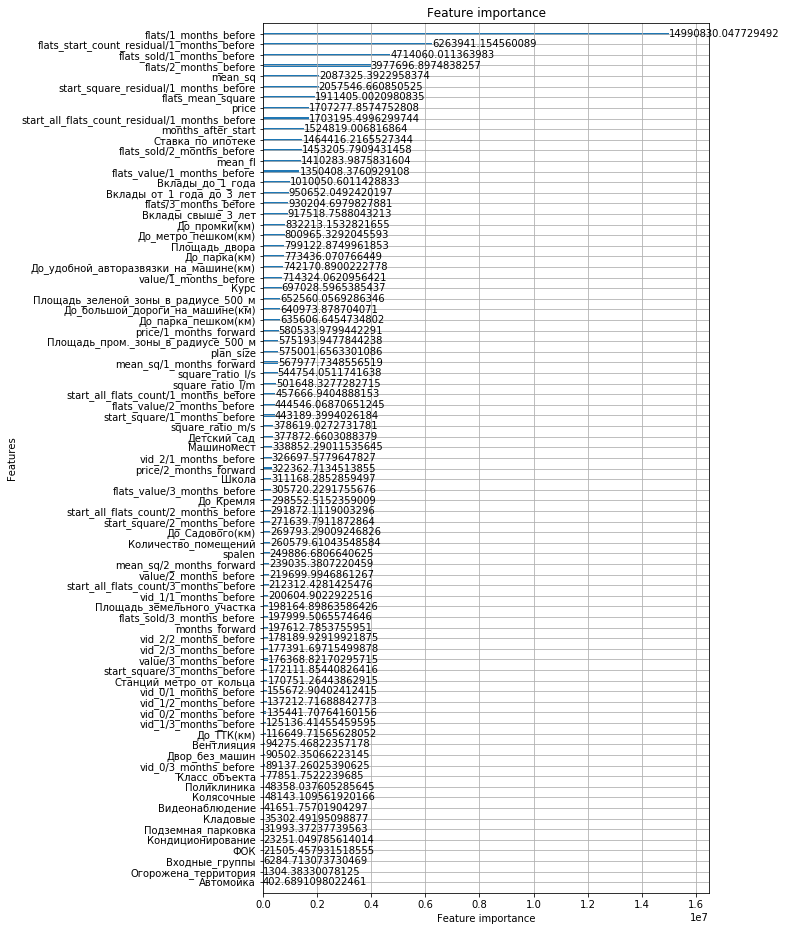

In [46]:
lgb.plot_importance(gbm, figsize=(8,16), importance_type='gain')

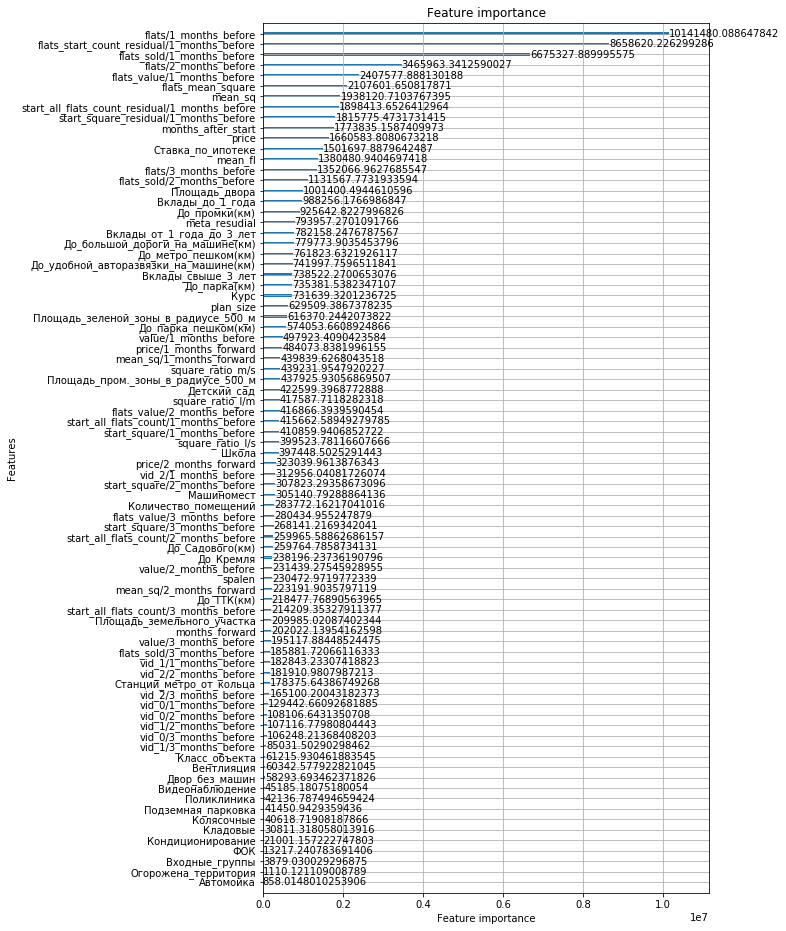

In [85]:
lgb.plot_importance(gbm, figsize=(8,16), importance_type='gain')

# Submit

In [119]:
submis = X_test.copy()
submis['value']= gbm.predict(X_test.drop(columns=['bulk_id','base_date']))
for col in key_category:
    submis[col] = key_encoder[col].inverse_transform(submis[col])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [120]:
if target_col == 'flats_sold':
    submis['value']= submis['value']*submis['flats_mean_square']
elif target_col == 'flats_value':
    pass
else:
    raise Exception()
pred_value = submis.groupby(['bulk_id','spalen','base_date','months_forward'])['value'].sum()

In [121]:
submis= pred_value.reset_index()

In [122]:
submis['months_forward'] = submis.months_forward.\
    apply(lambda m: (pd.to_datetime('2018-02-01')+relativedelta(months=m)).strftime("%Y-%m-%d"))

In [123]:
test_df['date1'] =test_df['date1'].apply(lambda d: pd.to_datetime(d).strftime("%Y-%m-%d"))

In [124]:
submis = test_df[['bulk_id', 'spalen', 'date1']].merge(submis[['bulk_id', 'spalen', 'months_forward','value']],
              left_on=['bulk_id', 'spalen', 'date1'],
                right_on = ['bulk_id', 'spalen', 'months_forward'], how='left')

In [126]:
submis['value'].reset_index().rename(columns={'index':'id'}).to_csv('baseline_4_200it.csv',index=False)

In [127]:
submis['value'][submis['value']<0]

Series([], Name: value, dtype: float64)

In [128]:
submis['value']

0        792.244963
1       1445.227959
2        136.715235
3        567.345219
4        801.513502
5       1387.699713
6        119.897242
7        579.208472
8        810.046243
9       1390.531716
10       148.697811
11       607.767286
12       510.778529
13       301.606897
14       151.094075
15       382.840624
16        29.852976
17        29.780636
18        30.228989
19        68.010292
20        40.389968
21       232.377030
22       287.856096
23       346.381113
24       602.259854
25        51.500208
26       447.562279
27       232.656626
28        89.239921
29       137.066571
           ...     
1740     212.211424
1741      41.764938
1742     144.126092
1743     386.288220
1744     794.598753
1745     403.656948
1746     104.313537
1747     146.196245
1748      44.035807
1749      70.707780
1750      19.716025
1751     126.963066
1752     906.335423
1753     738.300460
1754     739.308645
1755      33.498046
1756      63.611060
1757      34.555806
1758     103.934042


In [198]:
submis['value']

0        967.251544
1       1661.228548
2        158.147707
3        545.792816
4       1035.961441
5       1688.398215
6        186.194926
7        642.693493
8       1109.322477
9       1731.131455
10       203.135898
11       668.088244
12       468.821321
13       384.390250
14       231.059021
15       515.699924
16        29.639647
17        24.693254
18        18.902843
19        99.080719
20        42.410097
21       311.583325
22       354.418033
23       394.097815
24       684.040648
25        42.932577
26       519.239282
27       183.960441
28       118.785863
29       185.296338
           ...     
1740     188.259256
1741      -2.245310
1742     216.833480
1743     505.680559
1744     884.755206
1745     538.498736
1746     119.658779
1747     290.449550
1748      36.586046
1749      85.635222
1750      37.354197
1751     133.549025
1752    1144.132182
1753     959.015348
1754     808.229267
1755      29.534432
1756      76.158639
1757       3.266806
1758      89.715916


In [25]:
flat_df.iloc[1]

id_sec                                     846EA675-93FF-E411-8098-001EC9D56418
floor                                                                         2
spalen                                                                        1
stage_number                                                                  2
square                                                                     34.2
balcon                                                                        0
otdelka                                                         Не производится
plan0                                                                     1S-1*
id_bulk                                    4B3B6D6A-93FF-E411-8098-001EC9D56418
section                                                                       1
date_settle                                                 2017-03-15 21:00:00
date_salestart                                              2015-06-14 21:00:00
id_gk                                   